In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import os
from PIL import Image

from shutil import copyfile
import base64
from io import BytesIO
from IPython.display import HTML
import pickle
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Activation
from keras.layers import Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model

from mtcnn.mtcnn import MTCNN
# print version

import cv2
import copy

from tqdm import tqdm
import glob

In [7]:
augmented_images_df = pd.read_pickle('aug_2000_rows.pkl')

In [8]:
augmented_images_df = augmented_images_df.sample(frac=1)

In [9]:
augmented_images_df.head()

,neutralised_image,neutralised_original_image,crop_original_image,original_image,original_emotion,name,all_images,all_original_images
5200,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[12, 10, 9, 8, 6, 4, 5, 4, 6, 6, 6, 6, 5, 5, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[23, 20, 18, 14, 12, 11, 10, 8, 7, 5, 5, 5, 6...",happy,133,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[23, 20, 18, 14, 12, 11, 10, 8, 7, 5, 5, 5, 6..."
8158,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[255, 255, 255, 255, 255, 255, 254, 254, 254,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[255, 255, 255, 255, 255, 255, 255, 254, 254,...",fear,11,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[255, 255, 255, 255, 255, 255, 255, 254, 254,..."
799,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[4, 6, 7, 7, 11, 10, 8, 9, 9, 8, 17, 21, 25, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[70, 57, 46, 26, 8, 0, 1, 1, 2, 5, 5, 7, 8, 1...",happy,62,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[4, 6, 7, 7, 11, 10, 8, 9, 9, 8, 17, 21, 25, ..."
1147,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[63, 64, 64, 65, 64, 65, 65, 66, 68, 69, 69, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[65, 65, 66, 67, 65, 67, 69, 69, 69, 68, 68, ...",happy,91,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[63, 64, 64, 65, 64, 65, 65, 66, 68, 69, 69, ..."
3721,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[5, 4, 4, 4, 4, 4, 5, 5, 6, 7, 8, 9, 8, 4, 4,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[8, 6, 5, 4, 5, 4, 3, 3, 2, 2, 3, 4, 5, 6, 7,...",disgust,22,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[5, 4, 4, 4, 4, 4, 5, 5, 6, 7, 8, 9, 8, 4, 4,..."


In [10]:
use_reduced = int(input('Do you want to use a reduced data-set? (Enter 0 or 1) '))
print(use_reduced)


Do you want to use a reduced data-set? (Enter 0 or 1) 0
0


In [11]:
if(use_reduced == 1): 
    num_samples = 5000
    augmented_images_df = augmented_images_df.iloc[:num_samples]
else:
    augmented_images_df = augmented_images_df.iloc[:]
    


In [12]:
augmented_images_df = augmented_images_df[augmented_images_df['name'] != 895]
augmented_images_df = augmented_images_df[augmented_images_df['name'] != 157]
augmented_images_df = augmented_images_df[augmented_images_df['name'] != 147]


In [13]:
X_rec_origin, y_rec_origin = augmented_images_df[['all_original_images', 'original_image', 'neutralised_original_image']], augmented_images_df['name']

X_rec_origin_train, X_rec_origin_test, y_rec_origin_train, y_rec_origin_test = train_test_split(X_rec_origin, y_rec_origin, test_size=0.33, random_state=42)
X_rec_origin_train.reset_index(drop=True, inplace=True), X_rec_origin_test.reset_index(drop=True, inplace=True)
y_rec_origin_train.reset_index(drop=True, inplace=True), y_rec_origin_test.reset_index(drop=True, inplace=True)
X_rec_origin_train.shape, X_rec_origin_test.shape, y_rec_origin_train.shape, y_rec_origin_test.shape

((1335, 3), (658, 3), (1335,), (658,))

In [14]:
y_rec_origin_train

0        42
1       131
2        85
3       108
4       102
5        26
6       506
7       108
8        93
9       127
10       14
11       37
12       35
13      148
14      136
15       37
16      128
17      128
18      114
19       60
20      130
21       22
22      101
23      114
24       87
25       22
26       80
27       71
28       50
29       28
       ... 
1305     76
1306    128
1307    128
1308    126
1309     96
1310     26
1311    504
1312     64
1313    138
1314     10
1315     63
1316     80
1317     74
1318     26
1319     35
1320     61
1321     50
1322    125
1323     96
1324     34
1325    501
1326     42
1327     58
1328    132
1329     45
1330     76
1331    100
1332     84
1333     68
1334     54
Name: name, Length: 1335, dtype: object

In [15]:
indices = np.where((y_rec_origin_test.values).reshape(y_rec_origin_test.values.size, 1) == y_rec_origin_train.values)[1]
indices

array([ 420,  456,  530, ..., 1253, 1305, 1330], dtype=int64)

In [16]:
y_rec_origin_test

0       66
1      132
2       82
3       89
4       94
5      112
6      504
7       87
8      999
9       69
10      97
11      87
12      96
13      79
14      58
15      74
16     501
17      52
18      62
19     137
20     504
21     114
22     113
23     501
24      61
25      37
26     136
27     503
28     106
29      32
      ... 
628     26
629     63
630    129
631    128
632     89
633     62
634    137
635     91
636     55
637     69
638     55
639    999
640    503
641     42
642     75
643    505
644     45
645    501
646    151
647     55
648    111
649    131
650     88
651     42
652     45
653     89
654     22
655     22
656     93
657     76
Name: name, Length: 658, dtype: object

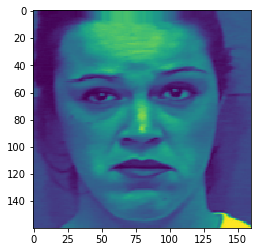

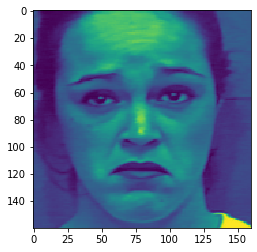

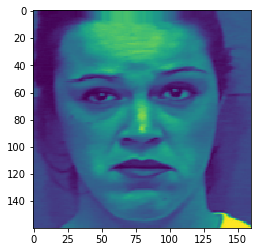

In [17]:
for i in ['all_original_images', 'original_image', 'neutralised_original_image']:
    plt.imshow(X_rec_origin_train.iloc[220][i])
    plt.show()

In [18]:
X_rec_origin_train['all_original_images'][0].shape

(160, 160)

# Pre-process images for FaceNet

In [19]:
def preprocess_images(gray,required_size=(160, 160)):
    ''' function to pre-process images for FaceNet '''
    
    
    image = Image.fromarray(gray)
    image = image.resize(required_size)
    image = image.convert('RGB')
    face_array = np.asarray(image)
    return face_array

In [20]:
for i in tqdm(range(X_rec_origin_train.shape[0]),desc = "Pre-processing images in training set for using FaceNet"):
    
    temp_im = preprocess_images(X_rec_origin_train['all_original_images'][i])
    X_rec_origin_train.at[i, 'all_original_images'] = temp_im
    
    temp_im2 = preprocess_images(X_rec_origin_train['original_image'][i])
    X_rec_origin_train.at[i, 'original_image'] = temp_im2
    
    temp_im3 = preprocess_images(X_rec_origin_train['neutralised_original_image'][i])
    X_rec_origin_train.at[i, 'neutralised_original_image'] = temp_im3

Pre-processing images in training set for using FaceNet: 100%|███████████████████| 1335/1335 [00:00<00:00, 2010.44it/s]


In [21]:
for i in tqdm(range(X_rec_origin_test.shape[0]),desc = "Pre-processing images in test set for using FaceNet"):
    
    temp_im = preprocess_images(X_rec_origin_test['all_original_images'][i])
    X_rec_origin_test.at[i, 'all_original_images'] = temp_im
    
    temp_im2 = preprocess_images(X_rec_origin_test['original_image'][i])
    X_rec_origin_test.at[i, 'original_image'] = temp_im2
    
    temp_im3 = preprocess_images(X_rec_origin_test['neutralised_original_image'][i])
    X_rec_origin_test.at[i, 'neutralised_original_image'] = temp_im3

Pre-processing images in test set for using FaceNet: 100%|█████████████████████████| 658/658 [00:00<00:00, 1551.87it/s]


(160, 160, 3)


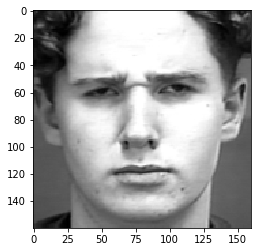

(160, 160, 3)


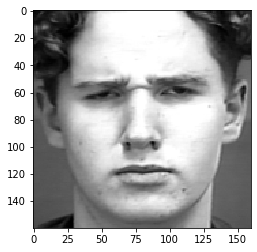

(160, 160, 3)


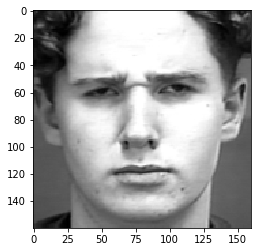

In [22]:
for i in ['all_original_images', 'original_image', 'neutralised_original_image']:
    plt.imshow(X_rec_origin_train.iloc[1][i])
    print(X_rec_origin_train.iloc[1][i].shape)
    plt.show()

# Generate embeddings for the faces

In [23]:

model = load_model('..\\Data\\Model\\model\\facenet_keras.h5')

print(model.inputs)
print(model.outputs)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\anan2\Anaconda3\envs\test\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Merge:0' shape=(?, 128) dtype=float32>]


In [24]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [25]:
X_rec_origin_train.columns

Index(['all_original_images', 'original_image', 'neutralised_original_image'], dtype='object')

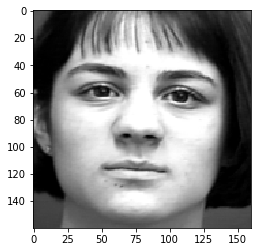

In [26]:
plt.imshow(X_rec_origin_train.iloc[100,0])

In [27]:
# convert each face in the train set to an embedding
newTrainX = list()
for i in tqdm(range(X_rec_origin_train.shape[0]),desc = "Converting images in training set to embeddings using FaceNet"):
    face_pixels = X_rec_origin_train.iloc[i,0]
    embedding = get_embedding(model, face_pixels)
    
    newTrainX.append(embedding)


Converting images in training set to embeddings using FaceNet: 100%|███████████████| 1335/1335 [01:35<00:00, 13.98it/s]


In [28]:
X_rec_origin_train = X_rec_origin_train.assign(all_images_embeddings = newTrainX)

In [29]:
# convert each face in the test set to an embedding
newTestX = list()
for i in tqdm(range(X_rec_origin_test.shape[0]),desc = "Converting images in test set to embeddings using FaceNet"):
    face_pixels = X_rec_origin_test.iloc[i,0]
    embedding = get_embedding(model, face_pixels)
    
    newTestX.append(embedding)


Converting images in test set to embeddings using FaceNet: 100%|█████████████████████| 658/658 [00:47<00:00, 13.75it/s]


In [30]:
X_rec_origin_test = X_rec_origin_test.assign(all_images_embeddings = newTestX)

In [31]:
X_rec_origin_test.columns


Index(['all_original_images', 'original_image', 'neutralised_original_image',
       'all_images_embeddings'],
      dtype='object')

In [32]:
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

(1335, 128)


In [33]:
newTestX = np.asarray(newTestX)
print(newTestX.shape)

(658, 128)


# Train an SVM to do the recognition

In [34]:
# load necessary libraries
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot


In [35]:
lab_train = (y_rec_origin_train.values).astype(str)
lab_train

array(['42', '131', '85', ..., '84', '68', '54'], dtype='<U3')

In [36]:
lab_test = (y_rec_origin_test.values).astype(str)
lab_test

array(['66', '132', '82', '89', '94', '112', '504', '87', '999', '69',
       '97', '87', '96', '79', '58', '74', '501', '52', '62', '137',
       '504', '114', '113', '501', '61', '37', '136', '503', '106', '32',
       '76', '55', '14', '501', '108', '133', '57', '65', '55', '109',
       '108', '109', '503', '54', '45', '81', '84', '70', '999', '67',
       '125', '28', '55', '87', '502', '92', '135', '77', '137', '45',
       '14', '129', '131', '71', '124', '119', '114', '70', '72', '109',
       '97', '148', '50', '22', '506', '108', '76', '45', '136', '503',
       '10', '64', '130', '999', '32', '70', '66', '502', '78', '78',
       '74', '75', '132', '67', '56', '95', '111', '102', '81', '115',
       '59', '84', '999', '88', '11', '35', '137', '138', '502', '88',
       '58', '35', '26', '62', '110', '26', '93', '61', '46', '57', '61',
       '133', '130', '139', '111', '34', '75', '95', '71', '58', '62',
       '135', '11', '129', '87', '14', '127', '59', '44', '117', '156',

In [37]:
print(type(lab_train),type(lab_test),sep = '\n')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [38]:
# load faces

testX_faces = X_rec_origin_test['all_original_images']
# load face embeddings
trainX, trainy, testX, testy = newTrainX, lab_train, newTestX, lab_test
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)


# fit model
#model_SVM = SVC(gamma=2, C=1, probability=True) #SVM with RBF Kernel
model_SVM = SVC(kernel='linear', probability=True)
model_SVM.fit(trainX, trainy)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [39]:
trainX.shape

(1335, 128)

## Performance evaluation

In [40]:
# prediction vector for the test set
yhat_accuracy = model_SVM.score(testX, testy)
print("Accuracy on test set = "+str(yhat_accuracy*100) + " %")

Accuracy on test set = 99.3920972644377 %


In [41]:
y_pred_tps = model_SVM.predict(testX)
c_mat_val = confusion_matrix(testy, y_pred_tps)
c_mat_val

array([[ 4,  0,  0, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  0],
       [ 0,  0,  3, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  3,  0],
       [ 0,  0,  0, ...,  0,  0, 11]], dtype=int64)

In [42]:
print(classification_report(testy, y_pred_tps))

C:\Users\anan2\Anaconda3\envs\test\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         8
           9       0.93      1.00      0.96        13
          10       0.00      0.00      0.00         3
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         4
          18       1.00    

Predicted: 52 (7.296 %)
Expected: 52


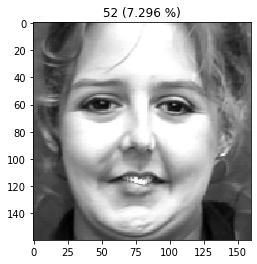

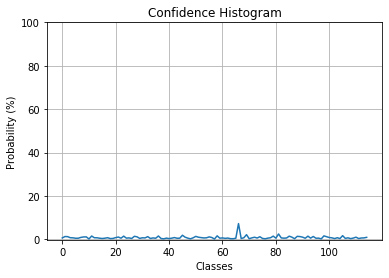

Predicted: 52 (7.840 %)
Expected: 52


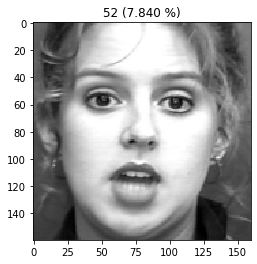

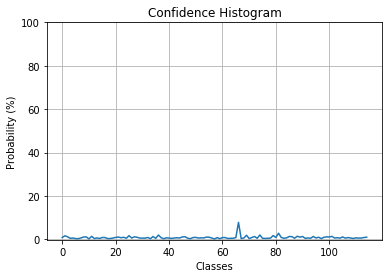

Predicted: 52 (7.136 %)
Expected: 52


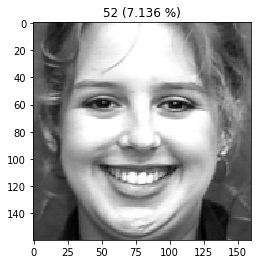

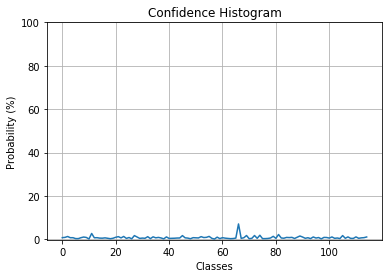

Predicted: 52 (7.440 %)
Expected: 52


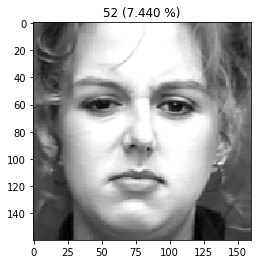

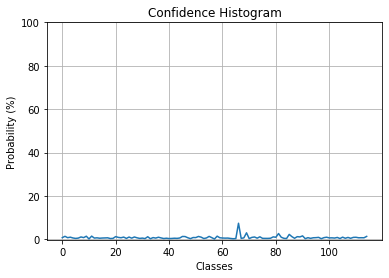

Predicted: 52 (8.214 %)
Expected: 52


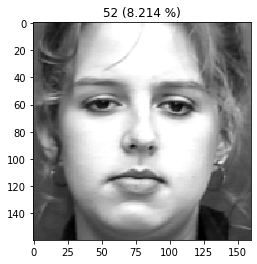

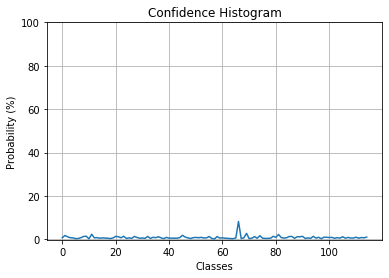

Predicted: 52 (7.376 %)
Expected: 52


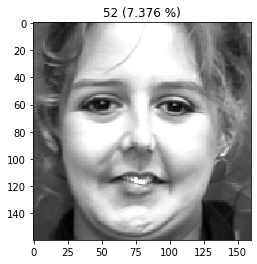

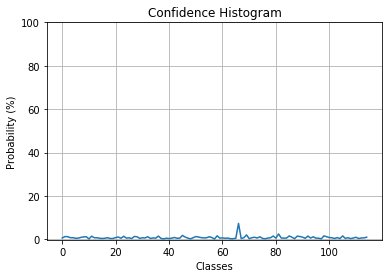

Predicted: 52 (6.933 %)
Expected: 52


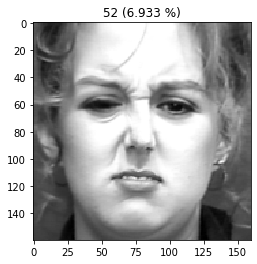

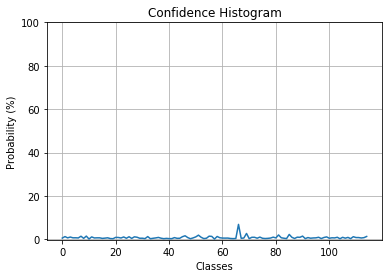

Predicted: 52 (8.270 %)
Expected: 52


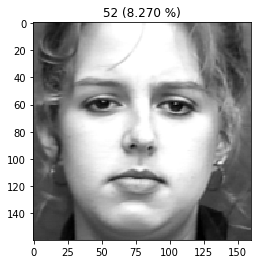

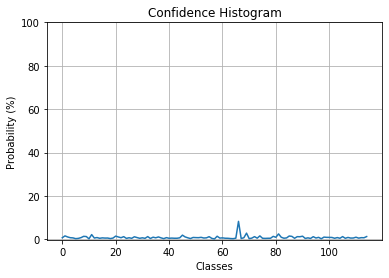

Predicted: 52 (7.279 %)
Expected: 52


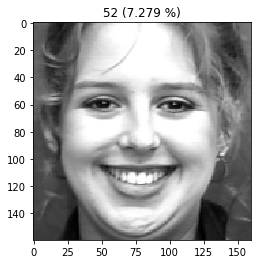

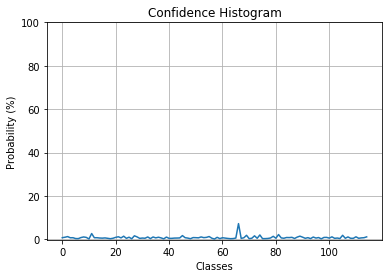

In [43]:
facenet_confidences_original = []
facenet_confidences_neutralised = []

for ind in range(testX.shape[0]):
    # test model on a random example from the test dataset
    selection = ind
    
    random_face_pixels = X_rec_origin_test.iloc[selection,0]
    random_face_emb = testX[selection]
    random_face_class = testy[selection]
    random_face_name = out_encoder.inverse_transform([random_face_class])
    # prediction for the face
    samples = expand_dims(random_face_emb, axis=0)
    yhat_class = model_SVM.predict(samples)
    
    yhat_prob = model_SVM.predict_proba(samples)
    
    
        
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    
    if np.array_equal(random_face_pixels , X_rec_origin_test['original_image'][selection]):
        facenet_confidences_original.append(class_probability)
    elif np.array_equal(random_face_pixels , X_rec_origin_test['neutralised_original_image'][selection]):
        facenet_confidences_neutralised.append(class_probability)
    else:
        pass #should never happen
    
    predict_names = out_encoder.inverse_transform(yhat_class)
    if(predict_names[0] == '52'):
        print('Predicted: %s (%.3f %%)' % (predict_names[0], class_probability))
        print('Expected: %s' % random_face_name[0])
       
        # plot for fun
        pyplot.imshow(random_face_pixels)
        title = '%s (%.3f %%)' % (predict_names[0], class_probability)
        pyplot.title(title)


        pyplot.show()
        pyplot.plot(yhat_prob.flatten() * 100)
        x1,x2,y1,y2 = plt.axis()

        plt.axis((x1,x2,y1,100))
        pyplot.ylabel("Probability (%)")
        pyplot.xlabel("Classes")
        pyplot.title("Confidence Histogram")
        pyplot.grid()

        pyplot.show()

## Plotting the Cumulative histogram

In [44]:
facenet_confidences_original = [float(i)*100/max(facenet_confidences_original) for i in facenet_confidences_original]
facenet_confidences_neutralised = [float(i)*100/max(facenet_confidences_neutralised) for i in facenet_confidences_neutralised]


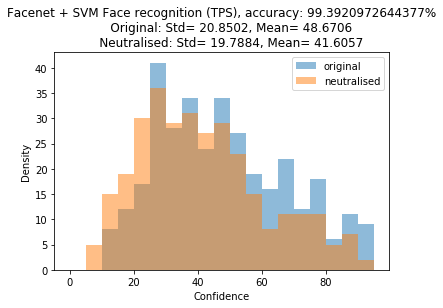

In [45]:
density_param = False
plt.hist(facenet_confidences_original, density = density_param, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(facenet_confidences_neutralised, density = density_param, alpha=0.5, bins=range(0,100,5), label='neutralised')
plt.ylabel('Density')
plt.xlabel('Confidence')
plt.title('Facenet + SVM Face recognition (TPS), accuracy: {}%\n \
    Original: Std= {}, Mean= {}\n \
    Neutralised: Std= {}, Mean= {}'.format( yhat_accuracy * 100, 
                                           np.around(np.std(np.asarray(facenet_confidences_original)),4),
                                           np.around(np.mean(np.asarray(facenet_confidences_original)),4),
                                           np.around(np.std(np.asarray(facenet_confidences_neutralised)),4),
                                           np.around(np.mean(np.asarray(facenet_confidences_neutralised)),4)))

plt.legend()

plt.savefig('Facenet_TPS_Facerecognition.png',bbox_inches='tight')

### The code in this cell is just for analyzing the number of training examples belonging to each class 

In [46]:
y_pred_shape_free_train = model_SVM.predict(trainX)
report = classification_report(trainy, y_pred_shape_free_train, output_dict=True)
df = pd.DataFrame(report).transpose()
df.head(30)

C:\Users\anan2\Anaconda3\envs\test\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,f1-score,precision,recall,support
0,1.000000,1.000000,1.0,13.0
1,1.000000,1.000000,1.0,15.0
2,1.000000,1.000000,1.0,4.0
3,1.000000,1.000000,1.0,14.0
4,1.000000,1.000000,1.0,4.0
5,1.000000,1.000000,1.0,8.0
6,1.000000,1.000000,1.0,6.0
7,1.000000,1.000000,1.0,11.0
8,1.000000,1.000000,1.0,8.0
9,1.000000,1.000000,1.0,28.0


In [47]:
print(trainX.shape,testX.shape,sep = '\n')

(1335, 128)
(658, 128)
